In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'densenet201', pretrained=True)
model.eval()

Using cache found in C:\Users\Otakuking/.cache\torch\hub\pytorch_vision_v0.9.0


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [3]:
batch_size = 16
learning_rate = 0.0001

transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='emotion3/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion3/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([16, 3, 224, 224])
out-size: torch.Size([3, 454, 1810])


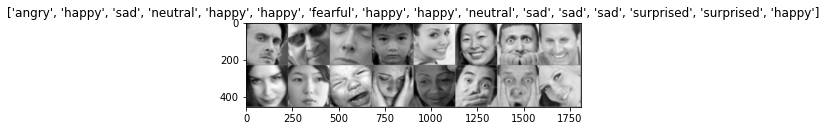

In [5]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [6]:
net = model
net = net.cuda() if device else net
net

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [8]:
n_epochs = 20
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'Densenet201_lr0.0001_adam_batch16_epoch20.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/20], Step [0/1248], Loss: 12.8590
Epoch [1/20], Step [20/1248], Loss: 2.0563
Epoch [1/20], Step [40/1248], Loss: 1.8323
Epoch [1/20], Step [60/1248], Loss: 1.8424
Epoch [1/20], Step [80/1248], Loss: 1.8410
Epoch [1/20], Step [100/1248], Loss: 1.2897
Epoch [1/20], Step [120/1248], Loss: 1.6333
Epoch [1/20], Step [140/1248], Loss: 1.7862
Epoch [1/20], Step [160/1248], Loss: 1.3963
Epoch [1/20], Step [180/1248], Loss: 1.2308
Epoch [1/20], Step [200/1248], Loss: 1.0268
Epoch [1/20], Step [220/1248], Loss: 2.3812
Epoch [1/20], Step [240/1248], Loss: 1.2985
Epoch [1/20], Step [260/1248], Loss: 1.4558
Epoch [1/20], Step [280/1248], Loss: 2.0211
Epoch [1/20], Step [300/1248], Loss: 1.5204
Epoch [1/20], Step [320/1248], Loss: 1.4320
Epoch [1/20], Step [340/1248], Loss: 1.6433
Epoch [1/20], Step [360/1248], Loss: 1.3422
Epoch [1/20], Step [380/1248], Loss: 1.7731
Epoch [1/20], Step [400/1248], Loss: 1.4463
Epoch [1/20], Step [420/1248], Loss: 1.3606
Epoch [1/20], Step [440/1248

Epoch [3/20], Step [1080/1248], Loss: 1.0950
Epoch [3/20], Step [1100/1248], Loss: 0.6621
Epoch [3/20], Step [1120/1248], Loss: 0.4486
Epoch [3/20], Step [1140/1248], Loss: 1.1106
Epoch [3/20], Step [1160/1248], Loss: 0.9892
Epoch [3/20], Step [1180/1248], Loss: 0.5595
Epoch [3/20], Step [1200/1248], Loss: 1.1482
Epoch [3/20], Step [1220/1248], Loss: 0.7487
Epoch [3/20], Step [1240/1248], Loss: 0.4024

train-loss: 1.0865, train-acc: 68.2465
validation loss: 0.9267, validation acc: 67.4127

Improvement-Detected, save-model
Epoch 4

Epoch [4/20], Step [0/1248], Loss: 0.7151
Epoch [4/20], Step [20/1248], Loss: 0.8426
Epoch [4/20], Step [40/1248], Loss: 0.7926
Epoch [4/20], Step [60/1248], Loss: 0.7629
Epoch [4/20], Step [80/1248], Loss: 0.6480
Epoch [4/20], Step [100/1248], Loss: 0.4436
Epoch [4/20], Step [120/1248], Loss: 0.6277
Epoch [4/20], Step [140/1248], Loss: 0.5132
Epoch [4/20], Step [160/1248], Loss: 0.4011
Epoch [4/20], Step [180/1248], Loss: 1.1087
Epoch [4/20], Step [200/1248]

Epoch [6/20], Step [880/1248], Loss: 0.6423
Epoch [6/20], Step [900/1248], Loss: 0.2543
Epoch [6/20], Step [920/1248], Loss: 0.3747
Epoch [6/20], Step [940/1248], Loss: 0.3150
Epoch [6/20], Step [960/1248], Loss: 0.5011
Epoch [6/20], Step [980/1248], Loss: 0.2151
Epoch [6/20], Step [1000/1248], Loss: 0.6244
Epoch [6/20], Step [1020/1248], Loss: 0.1383
Epoch [6/20], Step [1040/1248], Loss: 0.2025
Epoch [6/20], Step [1060/1248], Loss: 0.8040
Epoch [6/20], Step [1080/1248], Loss: 0.5593
Epoch [6/20], Step [1100/1248], Loss: 0.2558
Epoch [6/20], Step [1120/1248], Loss: 0.6179
Epoch [6/20], Step [1140/1248], Loss: 0.2570
Epoch [6/20], Step [1160/1248], Loss: 0.3408
Epoch [6/20], Step [1180/1248], Loss: 0.5428
Epoch [6/20], Step [1200/1248], Loss: 0.2010
Epoch [6/20], Step [1220/1248], Loss: 1.0916
Epoch [6/20], Step [1240/1248], Loss: 0.4080

train-loss: 0.8196, train-acc: 86.1423
validation loss: 0.9452, validation acc: 67.5518

Epoch 7

Epoch [7/20], Step [0/1248], Loss: 0.2787
Epoch [7/2

Epoch [9/20], Step [680/1248], Loss: 0.3925
Epoch [9/20], Step [700/1248], Loss: 0.1113
Epoch [9/20], Step [720/1248], Loss: 0.1991
Epoch [9/20], Step [740/1248], Loss: 0.5577
Epoch [9/20], Step [760/1248], Loss: 0.5181
Epoch [9/20], Step [780/1248], Loss: 0.3174
Epoch [9/20], Step [800/1248], Loss: 0.1095
Epoch [9/20], Step [820/1248], Loss: 0.1282
Epoch [9/20], Step [840/1248], Loss: 0.2532
Epoch [9/20], Step [860/1248], Loss: 0.0759
Epoch [9/20], Step [880/1248], Loss: 0.1135
Epoch [9/20], Step [900/1248], Loss: 0.0687
Epoch [9/20], Step [920/1248], Loss: 0.1727
Epoch [9/20], Step [940/1248], Loss: 0.0935
Epoch [9/20], Step [960/1248], Loss: 0.1012
Epoch [9/20], Step [980/1248], Loss: 0.2100
Epoch [9/20], Step [1000/1248], Loss: 0.5187
Epoch [9/20], Step [1020/1248], Loss: 0.0991
Epoch [9/20], Step [1040/1248], Loss: 0.2191
Epoch [9/20], Step [1060/1248], Loss: 0.1014
Epoch [9/20], Step [1080/1248], Loss: 0.1452
Epoch [9/20], Step [1100/1248], Loss: 0.0607
Epoch [9/20], Step [1120/1

Epoch [12/20], Step [420/1248], Loss: 0.0369
Epoch [12/20], Step [440/1248], Loss: 0.0641
Epoch [12/20], Step [460/1248], Loss: 0.3270
Epoch [12/20], Step [480/1248], Loss: 0.0812
Epoch [12/20], Step [500/1248], Loss: 0.0382
Epoch [12/20], Step [520/1248], Loss: 0.1423
Epoch [12/20], Step [540/1248], Loss: 0.0569
Epoch [12/20], Step [560/1248], Loss: 0.0553
Epoch [12/20], Step [580/1248], Loss: 0.0140
Epoch [12/20], Step [600/1248], Loss: 0.0266
Epoch [12/20], Step [620/1248], Loss: 0.0476
Epoch [12/20], Step [640/1248], Loss: 0.1703
Epoch [12/20], Step [660/1248], Loss: 0.0302
Epoch [12/20], Step [680/1248], Loss: 0.1731
Epoch [12/20], Step [700/1248], Loss: 0.4308
Epoch [12/20], Step [720/1248], Loss: 0.4385
Epoch [12/20], Step [740/1248], Loss: 0.0749
Epoch [12/20], Step [760/1248], Loss: 0.0383
Epoch [12/20], Step [780/1248], Loss: 0.1968
Epoch [12/20], Step [800/1248], Loss: 0.1141
Epoch [12/20], Step [820/1248], Loss: 0.1651
Epoch [12/20], Step [840/1248], Loss: 0.0838
Epoch [12/

Epoch [15/20], Step [140/1248], Loss: 0.0133
Epoch [15/20], Step [160/1248], Loss: 0.0560
Epoch [15/20], Step [180/1248], Loss: 0.1666
Epoch [15/20], Step [200/1248], Loss: 0.0218
Epoch [15/20], Step [220/1248], Loss: 0.0266
Epoch [15/20], Step [240/1248], Loss: 0.0571
Epoch [15/20], Step [260/1248], Loss: 0.0088
Epoch [15/20], Step [280/1248], Loss: 0.0912
Epoch [15/20], Step [300/1248], Loss: 0.0415
Epoch [15/20], Step [320/1248], Loss: 0.0337
Epoch [15/20], Step [340/1248], Loss: 0.0797
Epoch [15/20], Step [360/1248], Loss: 0.0565
Epoch [15/20], Step [380/1248], Loss: 0.0404
Epoch [15/20], Step [400/1248], Loss: 0.0149
Epoch [15/20], Step [420/1248], Loss: 0.0146
Epoch [15/20], Step [440/1248], Loss: 0.0657
Epoch [15/20], Step [460/1248], Loss: 0.0147
Epoch [15/20], Step [480/1248], Loss: 0.0140
Epoch [15/20], Step [500/1248], Loss: 0.0477
Epoch [15/20], Step [520/1248], Loss: 0.0440
Epoch [15/20], Step [540/1248], Loss: 0.3055
Epoch [15/20], Step [560/1248], Loss: 0.0435
Epoch [15/

Epoch [17/20], Step [1180/1248], Loss: 0.3884
Epoch [17/20], Step [1200/1248], Loss: 0.0600
Epoch [17/20], Step [1220/1248], Loss: 0.0630
Epoch [17/20], Step [1240/1248], Loss: 0.0281

train-loss: 0.3834, train-acc: 96.7034
validation loss: 1.2509, validation acc: 68.5761

Epoch 18

Epoch [18/20], Step [0/1248], Loss: 0.0058
Epoch [18/20], Step [20/1248], Loss: 0.0479
Epoch [18/20], Step [40/1248], Loss: 0.0174
Epoch [18/20], Step [60/1248], Loss: 0.0149
Epoch [18/20], Step [80/1248], Loss: 0.0198
Epoch [18/20], Step [100/1248], Loss: 0.0506
Epoch [18/20], Step [120/1248], Loss: 0.1981
Epoch [18/20], Step [140/1248], Loss: 0.0117
Epoch [18/20], Step [160/1248], Loss: 0.0041
Epoch [18/20], Step [180/1248], Loss: 0.0419
Epoch [18/20], Step [200/1248], Loss: 0.0021
Epoch [18/20], Step [220/1248], Loss: 0.0403
Epoch [18/20], Step [240/1248], Loss: 0.0125
Epoch [18/20], Step [260/1248], Loss: 0.0177
Epoch [18/20], Step [280/1248], Loss: 0.0153
Epoch [18/20], Step [300/1248], Loss: 0.0974
Ep

Epoch [20/20], Step [920/1248], Loss: 0.0248
Epoch [20/20], Step [940/1248], Loss: 0.0465
Epoch [20/20], Step [960/1248], Loss: 0.0182
Epoch [20/20], Step [980/1248], Loss: 0.0408
Epoch [20/20], Step [1000/1248], Loss: 0.1920
Epoch [20/20], Step [1020/1248], Loss: 0.1321
Epoch [20/20], Step [1040/1248], Loss: 0.0588
Epoch [20/20], Step [1060/1248], Loss: 0.0060
Epoch [20/20], Step [1080/1248], Loss: 0.3265
Epoch [20/20], Step [1100/1248], Loss: 0.0189
Epoch [20/20], Step [1120/1248], Loss: 0.0204
Epoch [20/20], Step [1140/1248], Loss: 0.0970
Epoch [20/20], Step [1160/1248], Loss: 0.0166
Epoch [20/20], Step [1180/1248], Loss: 0.0075
Epoch [20/20], Step [1200/1248], Loss: 0.0234
Epoch [20/20], Step [1220/1248], Loss: 0.0372
Epoch [20/20], Step [1240/1248], Loss: 0.0474

train-loss: 0.3381, train-acc: 97.5251
validation loss: 1.2957, validation acc: 67.5645



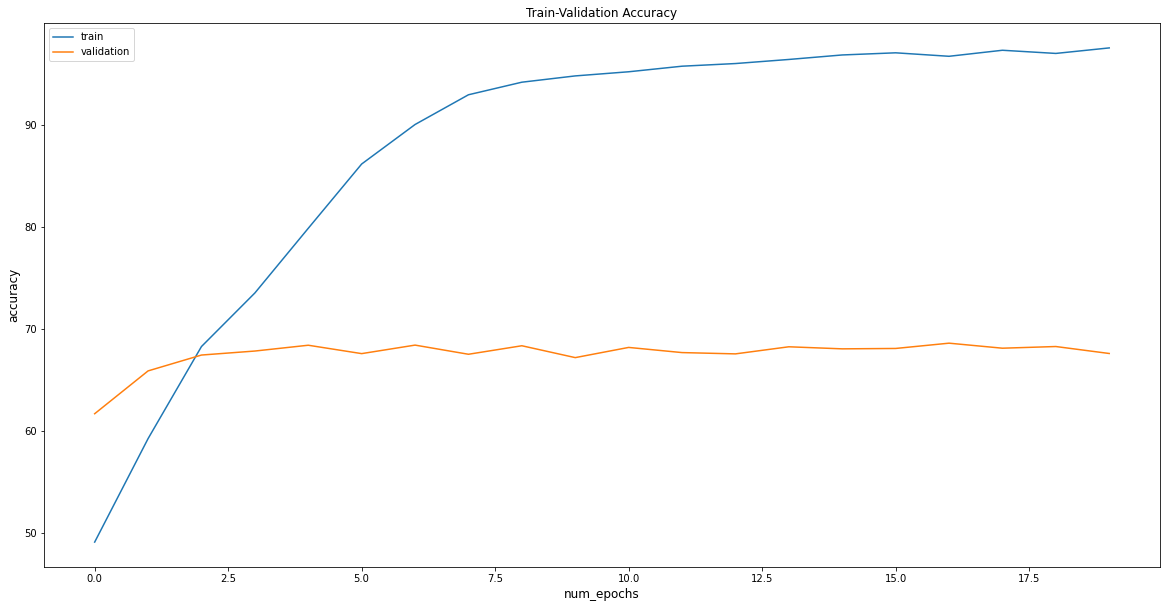

In [9]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

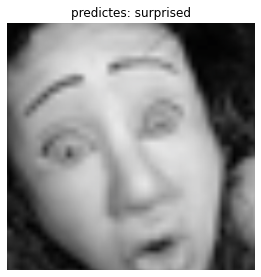

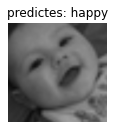

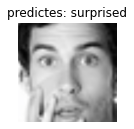

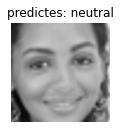

In [10]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()